In [ ]:
print(torch.cuda.is_available())  # Should return True

True


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10] - Train Loss: 0.3363, Train Acc: 0.8759, Val Loss: 0.3870, Val Acc: 0.8765
Epoch [2/10] - Train Loss: 0.0988, Train Acc: 0.9669, Val Loss: 0.6028, Val Acc: 0.8120
Epoch [3/10] - Train Loss: 0.0368, Train Acc: 0.9875, Val Loss: 0.2859, Val Acc: 0.8910
Epoch [4/10] - Train Loss: 0.0165, Train Acc: 0.9950, Val Loss: 0.4120, Val Acc: 0.8550
Epoch [5/10] - Train Loss: 0.0236, Train Acc: 0.9916, Val Loss: 0.4331, Val Acc: 0.8880
Epoch [6/10] - Train Loss: 0.0034, Train Acc: 0.9994, Val Loss: 0.9472, Val Acc: 0.8440
Epoch [7/10] - Train Loss: 0.0031, Train Acc: 0.9997, Val Loss: 0.3462, Val Acc: 0.9105
Epoch [8/10] - Train Loss: 0.0025, Train Acc: 0.9997, Val Loss: 0.8744, Val Acc: 0.8660
Epoch [9/10] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.8205, Val Acc: 0.8710
Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.8446, Val Acc: 0.8695


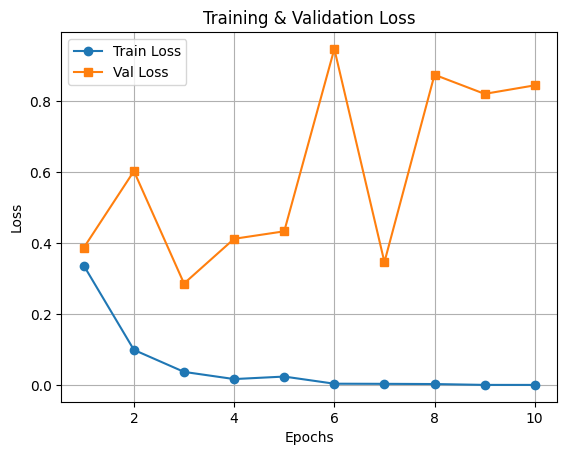

Model saved as vit_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm  # Pretrained ViT models
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
data_dir = "/content/drive/MyDrive/Hyper spectral imaging/Small_Intestine_Ulcer"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load pre-trained ViT model and modify classifier
num_classes = len(train_dataset.classes)
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)  # Reduce LR every 5 epochs

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step()  # Update learning rate

# Plot loss curve
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Save trained model
torch.save(model.state_dict(), "vit_model.pth")
print("Model saved as vit_model.pth")

Classification Report:
                       precision    recall  f1-score   support

            0_normal       0.99      1.00      1.00       200
1_ulcerative_colitis       0.95      0.52      0.67       200
            2_polyps       0.67      0.97      0.80       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.87       800
           macro avg       0.90      0.87      0.86       800
        weighted avg       0.90      0.87      0.86       800



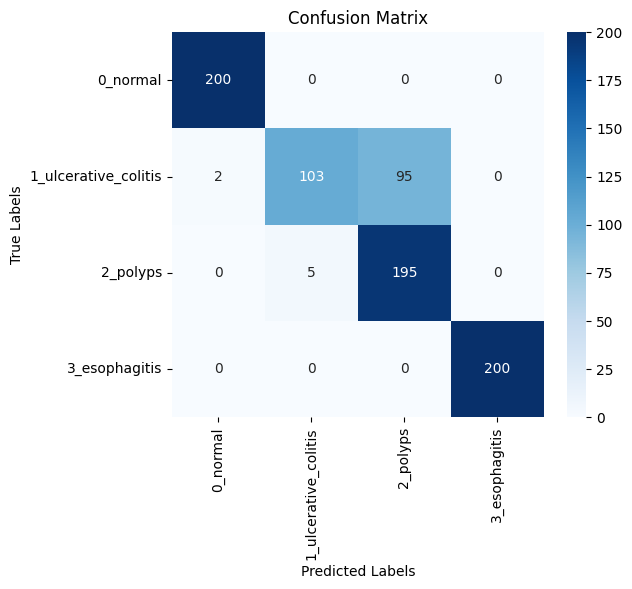

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained ViT model
num_classes = 4  # Update based on your dataset
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load("vit_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load test dataset
test_dir = "/content/drive/MyDrive/Hyper spectral imaging/Small_Intestine_Ulcer/test"  # Update path
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class labels
class_names = test_dataset.classes

# Lists to store true labels and predictions
true_labels = []
pred_labels = []

# Perform inference on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute Precision, Recall, F1-score
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
